# 과적합 해결

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [19]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [20]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [21]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)    # (배치 크기, h, w) -> (배치 크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [22]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [23]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2921, Accuracy: 0.9137
Epoch 2 | Val Loss: 0.1991, Accuracy: 0.9419
Epoch 3 | Val Loss: 0.1635, Accuracy: 0.9517
Epoch 4 | Val Loss: 0.1692, Accuracy: 0.9503
Epoch 5 | Val Loss: 0.1279, Accuracy: 0.9620

배치 정규화 적용
Epoch 1 | Val Loss: 0.1272, Accuracy: 0.9618
Epoch 2 | Val Loss: 0.1043, Accuracy: 0.9677
Epoch 3 | Val Loss: 0.0909, Accuracy: 0.9732
Epoch 4 | Val Loss: 0.0841, Accuracy: 0.9751
Epoch 5 | Val Loss: 0.0845, Accuracy: 0.9753


In [24]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1267, Accuracy: 0.9626
Epoch 2 | Val Loss: 0.1007, Accuracy: 0.9696
Epoch 3 | Val Loss: 0.0877, Accuracy: 0.9725
Epoch 4 | Val Loss: 0.0879, Accuracy: 0.9732
Epoch 5 | Val Loss: 0.0815, Accuracy: 0.9749
batch size: 32
Epoch 1 | Val Loss: 0.1191, Accuracy: 0.9644
Epoch 2 | Val Loss: 0.1001, Accuracy: 0.9683
Epoch 3 | Val Loss: 0.0988, Accuracy: 0.9690
Epoch 4 | Val Loss: 0.0932, Accuracy: 0.9711
Epoch 5 | Val Loss: 0.0827, Accuracy: 0.9751
batch size: 128
Epoch 1 | Val Loss: 0.1550, Accuracy: 0.9555
Epoch 2 | Val Loss: 0.1203, Accuracy: 0.9626
Epoch 3 | Val Loss: 0.0899, Accuracy: 0.9715
Epoch 4 | Val Loss: 0.0911, Accuracy: 0.9717
Epoch 5 | Val Loss: 0.1359, Accuracy: 0.9589


### 드롭아웃 적용

In [25]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [26]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2600, Accuracy: 0.9221
Epoch 2 | Val Loss: 0.1929, Accuracy: 0.9423
Epoch 3 | Val Loss: 0.1578, Accuracy: 0.9517
Epoch 4 | Val Loss: 0.1416, Accuracy: 0.9577
Epoch 5 | Val Loss: 0.1424, Accuracy: 0.9543
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3409, Accuracy: 0.9012
Epoch 2 | Val Loss: 0.3043, Accuracy: 0.9137
Epoch 3 | Val Loss: 0.2715, Accuracy: 0.9203
Epoch 4 | Val Loss: 0.2487, Accuracy: 0.9289
Epoch 5 | Val Loss: 0.2387, Accuracy: 0.9327
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.4210, Accuracy: 0.6988
Epoch 2 | Val Loss: 1.3169, Accuracy: 0.7070
Epoch 3 | Val Loss: 1.3379, Accuracy: 0.6911
Epoch 4 | Val Loss: 1.2275, Accuracy: 0.7151
Epoch 5 | Val Loss: 1.2442, Accuracy: 0.6836


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [27]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [28]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)

Epoch 1 | Val Loss: 0.4122, Accuracy: 0.8790
Epoch 2 | Val Loss: 0.3249, Accuracy: 0.9065
Epoch 3 | Val Loss: 0.2861, Accuracy: 0.9173
Epoch 4 | Val Loss: 0.2706, Accuracy: 0.9222
Epoch 5 | Val Loss: 0.2536, Accuracy: 0.9267

Epoch 1 | Val Loss: 0.1475, Accuracy: 0.9577
Epoch 2 | Val Loss: 0.1218, Accuracy: 0.9627
Epoch 3 | Val Loss: 0.1102, Accuracy: 0.9676
Epoch 4 | Val Loss: 0.1273, Accuracy: 0.9627
Epoch 5 | Val Loss: 0.1155, Accuracy: 0.9652


### Learning Rate Scheduler 적용

In [29]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        scheduler.step()
        print(f"Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}")

In [31]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.3312, Accuracy: 0.8987, LearningRate: 0.01
Epoch 2 | Val Loss: 0.2972, Accuracy: 0.9147, LearningRate: 0.01
Epoch 3 | Val Loss: 0.2452, Accuracy: 0.9297, LearningRate: 0.001
Epoch 4 | Val Loss: 0.1558, Accuracy: 0.9547, LearningRate: 0.001
Epoch 5 | Val Loss: 0.1556, Accuracy: 0.9565, LearningRate: 0.001
Epoch 6 | Val Loss: 0.1539, Accuracy: 0.9558, LearningRate: 0.0001
Epoch 7 | Val Loss: 0.1451, Accuracy: 0.9593, LearningRate: 0.0001
Epoch 8 | Val Loss: 0.1454, Accuracy: 0.9595, LearningRate: 0.0001
Epoch 9 | Val Loss: 0.1445, Accuracy: 0.9595, LearningRate: 1e-05
Epoch 10 | Val Loss: 0.1441, Accuracy: 0.9597, LearningRate: 1e-05


### 조기 종료 적용

In [32]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses

In [33]:
# !pip install skorch

In [34]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [35]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.3117, Accuracy: 0.9080
Epoch 2 | Loss: 0.3622, Accuracy: 0.8928
Epoch 3 | Loss: 0.3266, Accuracy: 0.9082
Epoch 4 | Loss: 0.2592, Accuracy: 0.9256
Epoch 5 | Loss: 0.2858, Accuracy: 0.9164
Epoch 6 | Loss: 0.2687, Accuracy: 0.9249
Epoch 7 | Loss: 0.2656, Accuracy: 0.9273
Epoch 8 | Loss: 0.2985, Accuracy: 0.9233
Epoch 9 | Loss: 0.2767, Accuracy: 0.9260
Epoch 10 | Loss: 0.2647, Accuracy: 0.9303
Epoch 11 | Loss: 0.2681, Accuracy: 0.9306
Epoch 12 | Loss: 0.2836, Accuracy: 0.9260
Epoch 13 | Loss: 0.2778, Accuracy: 0.9303
Epoch 14 | Loss: 0.2423, Accuracy: 0.9365
Epoch 15 | Loss: 0.2707, Accuracy: 0.9355
Epoch 16 | Loss: 0.2905, Accuracy: 0.9316
Epoch 17 | Loss: 0.3243, Accuracy: 0.9267
Epoch 18 | Loss: 0.2753, Accuracy: 0.9253
Epoch 19 | Loss: 0.2619, Accuracy: 0.9337
Epoch 20 | Loss: 0.3218, Accuracy: 0.9237
Epoch 21 | Loss: 0.2763, Accuracy: 0.9318
Epoch 22 | Loss: 0.2943, Accuracy: 0.9308
Epoch 23 | Loss: 0.2774, Accuracy: 0.9312
Epoch 24 | Loss: 0.3250, Accuracy: 0.9287
E

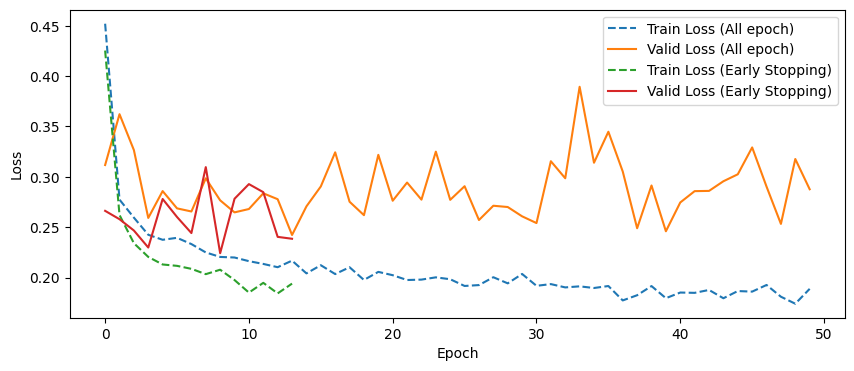

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label="Train Loss (Early Stopping)", linestyle='dashed')
plt.plot(val_es_losses, label="Valid Loss (Early Stopping)")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (L1, )L2 적용

In [37]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
     
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
            break

    return train_losses, val_losses

In [38]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(),lr=0.01,weight_decay=0.0, momentum=0.9)
train_losses, val_losses = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weighth_decay=0.01, momentum=0.9)
train_reg(model_reg, train_losses, val_losses, optim_reg)


Epoch 1 | Loss: 0.2564, Accuracy: 0.9214
조기 종료 epoch 1 | Train Loss: 0.4608, Val Loss: 0.2564, Accuracy: 0.9214


TypeError: SGD.__init__() got an unexpected keyword argument 'weighth_decay'